# p53 Experiment in GPJax

Re-implementation of latent force functions using GPJax library

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from p53_dataset import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


The original data from *Barenco et al.* used a training set of $5$ known $p53$ target genes:

| **Target** | **Probeset** |
|----------|----------|
| *DDB2* | 203409_at  |
| *p21*  | 202284_s_at   |
| *SESN1/hPA26*   | 218346_s_at   |
| *BIK*   | 205780_at  |
| *TNFRSF10b*   | 209294_x_at, 209295_at, 210405_x_at   |

In [2]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

In [3]:
def plot_all_genes_expression(original_df, transformed_expressions, gene_names, times):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot all original expressions on the first subplot
    for gene_name in gene_names:
        # Calculate the mean of triplicates for the original expression levels
        original_means = original_df.loc[gene_name].values.reshape(7, 3).mean(axis=1)
        axes[0].plot(times, original_means, '-o', label=gene_name)
        
    axes[0].set_title('Original Expression Levels')
    axes[0].set_xlabel('Time (hours)')
    axes[0].set_ylabel('Expression Level')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot all log-normalized expressions on the second subplot
    for i, gene_name in enumerate(gene_names):
        # Calculate the mean of triplicates for the transformed expression levels
        transformed_means = transformed_expressions[i].reshape(7, 3).mean(axis=1)
        axes[1].plot(times, transformed_means, '-o', label=gene_name)
        
    axes[1].set_title('Log-normalized Expression Levels')
    axes[1].set_xlabel('Time (hours)')
    axes[1].set_ylabel('Transformed Expression Level')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

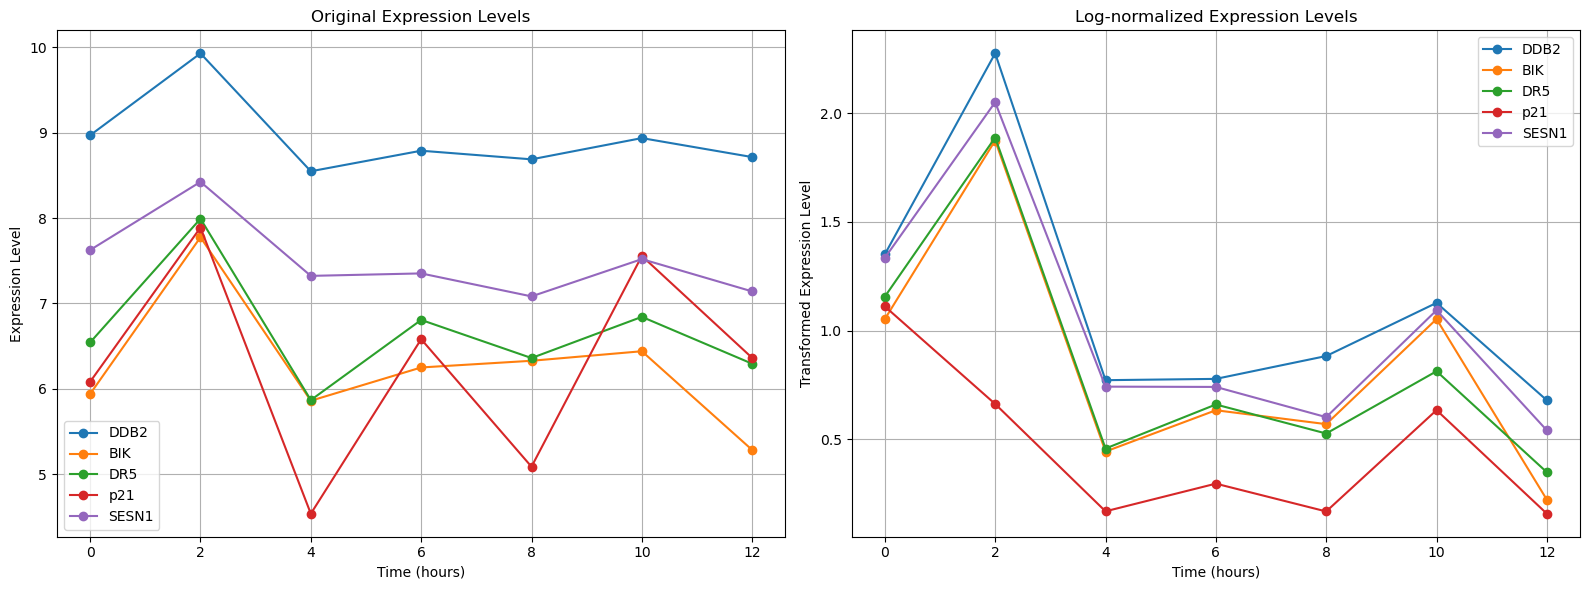

In [4]:
gene_names = ['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53']  # Assuming these are your genes of interest
plot_all_genes_expression(original_genes_df, genes_transformed.swapaxes(0, 1), gene_names[:-1], times)

## Gaussian process implementation

Now that the data has been correctly pre-processed the Gaussian processes (GPs) can be implemented in `GPJax`.

In [5]:
p53_data = JAXP53_Data(replicate=2)
train_t , train_y = flatten_dataset_jax(p53_data)
type(train_t), type(train_y)

(jaxlib.xla_extension.ArrayImpl, jaxlib.xla_extension.ArrayImpl)

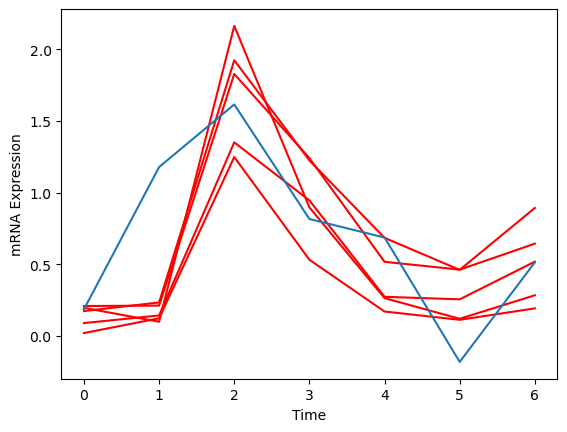

In [6]:
for i in range(5):
    plt.plot(p53_data.m_observed[0, i], color='red')
plt.plot(p53_data.f_observed[0, 0])
plt.xlabel('Time')
plt.ylabel('mRNA Expression')
plt.show()

In [7]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

## Using GPJax for transcriptional regulation modelling

1. Define GP Model
   - define kernel (RBF)
   - define likelihood
   - define mean function
2. Set the prior (done implicitly through choice of kernel & mean function)
3. Optimise hyperparameters of the GP model based on data
4. Make predictions & plot results

In [8]:
import gpjax as gpx
import jax.random as jr
from jax import jit

# Set random key
key = jr.PRNGKey(123)

# Prepare data (GPJax expects inputs as a 2D array)
X = train_t.reshape(-1, 1) 
Y = train_y.reshape(-1, 1)

x_test = np.linspace(0, 12, 100).reshape(-1, 1)
p53_gpjax_dataset = gpx.Dataset(X, Y)

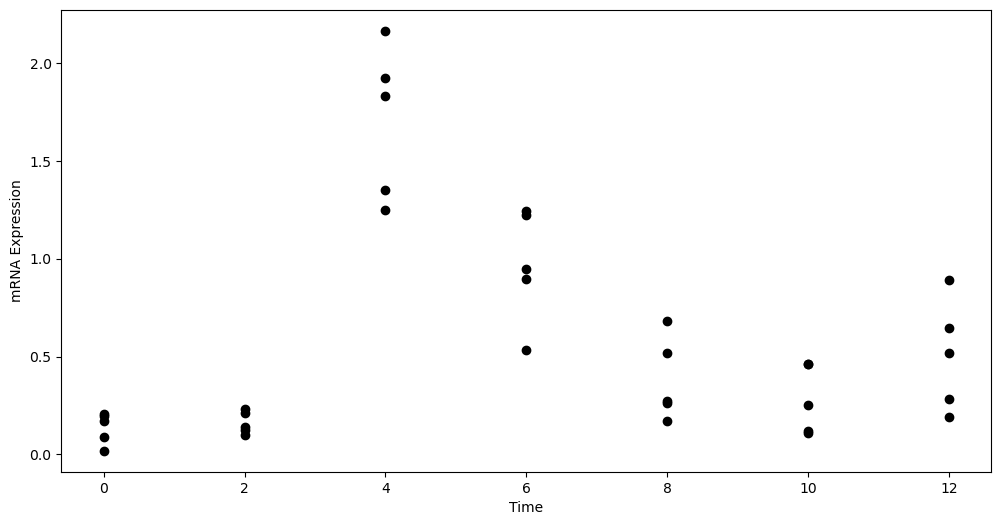

In [9]:
# Plot X & Y data
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'o', color='black')
plt.xlabel('Time')
plt.ylabel('mRNA Expression')
plt.show()

In [10]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(kernel, meanf)

In [11]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    return ax

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


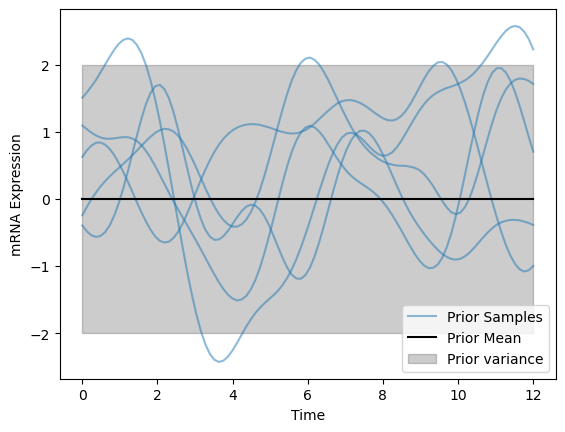

In [12]:
prior_dist = prior.predict(x_test)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(5,))

fig, ax = plt.subplots()
ax.plot(x_test, samples.T, alpha=0.5, color='C0', label = 'Prior Samples')
ax.plot(x_test, prior_mean, color='black', label = 'Prior Mean')
ax.fill_between(x_test.flatten(), prior_mean - 2 * np.sqrt(prior_std), prior_mean + 2 * np.sqrt(prior_std), color='black', alpha=0.2, label = 'Prior variance')
ax.set_xlabel('Time')
ax.set_ylabel('mRNA Expression')

ax.legend(loc='best')
ax = clean_legend(ax)

Having defined our GP, we proceed to define a description of our data $\mathcal{D}$ conditional on our knowledge of $f(\cdot)$ --- this is exactly the notion of a likelihood function $p(\mathcal{D} | f(\cdot))$. While the choice of likelihood is a critical in Bayesian modelling, for simplicity we consider a Gaussian with noise parameter $\alpha$

In [13]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)

The posterior is proportional to the prior multiplied by the likelihood, written as
$$ 
p(f(\cdot) | \mathcal{D}) \propto p(f(\cdot)) * p(\mathcal{D} | f(\cdot)).
$$

Mimicking this construct, the posterior is established in GPJax through the `*` operator.

In [14]:
posterior = prior * likelihood

In [15]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=p53_gpjax_dataset)

Array(40.82697246, dtype=float64)

In [16]:
negative_mll = jit(negative_mll)

Can now define an optimiser, I will use the `bfgs` optimiser from the `GPjax regression` tutorial

In [17]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=p53_gpjax_dataset,
)

Initial loss is 40.826972456045134
Optimization was successful
Final loss is 12.420296606647085 after 18 iterations


# Prediction

Now that the posterior has been defined with optimised hyperparameter values, the GP's predictive distribution can be queried at novel test inputs. To achieve this, the defined `posterior` and `likelihood` are used at the test inputs to obtain the predictive distribution as a `Distrax` multivariate Gaussian upon which `mean` and `stddev` can be used to extract the predictive mean and standard deviation.

In [18]:
latent_dist = opt_posterior.predict(x_test, train_data=p53_gpjax_dataset)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

With the predictions and their uncertainties acquired, the GP's performance can be plotted

In [19]:
import matplotlib as mpl
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

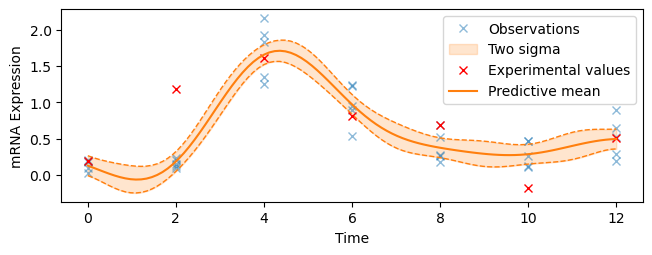

In [20]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(X, Y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    x_test.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)

ax.plot(
    list(range(0,13,2)), f_observed, "x", label="Experimental values", color='red',
)

ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Expression")
ax = clean_legend(ax)